<h2>Example 2: Persistent Contrail, Impose Saturation Depth</h2>
In this example, the ambient relative humidity is set to a value that allows a contrail to persist. When APCEMM knows that the contrail may persist, the results from EPM will be used as the inputs for the mature plume model (MPM). The MPM then runs until either the vast majority of ice crystals have subliminated, or the simulation time reaches the plume process time as specified in the input file (as is the case here). The contrail would otherwise persist for over 24 hours with these parameters.

<h4>Specifying Meteorological Conditions in APCEMM</h4>
To run APCEMM, the user must select at least one of "Use met input", "Impose moist layer depth", or "Impose lapse rate" in the Meteorology Menu. In this case, we have specified a supersaturated layer depth of 1000 meters. Imposing a moist layer depth will take precedent over imposing the lapse rate due to the conditions required to fulfill a specified depth. The use of meteorological input is discussed in Example 3.

In [11]:
#Import Libs and setup plotting settings
import os.path
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

SMALL_SIZE = 6
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
#Process timeseries data and create lists for time-dependent variables (time, ice mass, num particles, etc)
t = []
ds_t = []
ice_mass = []
total_h2o_mass = []
num_particles = []
END_OF_NC_FILES = False
i = 0
while END_OF_NC_FILES == False:
    for j in range(6):
        
        filename = "APCEMM_out/ts_aerosol_case0_"
        if i < 10:
            filename = filename + "0"
        filename = filename + str(i)
        if j == 0:
            filename = filename + "0"
        filename = filename + str(j*10) +".nc"
        if not os.path.exists(filename):
            END_OF_NC_FILES = True
            break
        ds = xr.open_dataset(filename, engine = "netcdf4", decode_times = False)
        ds_t.append(ds)
        t.append(i*60 + j*10)
        ice_mass.append(ds["Ice Mass"])
        num_particles.append(ds["Number Ice Particles"])
        
        dx = abs(ds["x"][-1] - ds["x"][0])/len(ds["x"])
        dy = abs(ds["y"][-1] - ds["y"][0])/len(ds["y"])

        h2o_mass = np.sum(ds["H2O"]) * 1e6 / 6.022e23 * 0.018 * dx*dy + ds["Ice Mass"]
        total_h2o_mass.append(h2o_mass.values)
    i = i + 1

print("length of ds_t: " + str(len(ds_t)))


length of ds_t: 31


In [19]:
#Things to help with post-processing
def removeLow(arr, cutoff = 1e-3):
    func = lambda x: (x > cutoff) * x
    vfunc = np.vectorize(func)
    return vfunc(arr)

X, Y = np.meshgrid(ds_t[0]['x'], ds_t[0]['y'])


In [20]:
#Let's take a look at the format of the data
ds_t[0]

<xarray.Dataset>
Dimensions:                      (x: 2048, y: 192, r_b: 39, r: 38, t: 1)
Coordinates:
  * x                            (x) float32 -9.995e+04 -9.985e+04 ... 9.995e+04
  * y                            (y) float32 -1.494e+03 -1.483e+03 ... 644.4
  * r_b                          (r_b) float32 5e-08 6.082e-08 ... 8.559e-05
  * r                            (r) float32 5.541e-08 6.74e-08 ... 7.798e-05
  * t                            (t) float32 0.0
Data variables: (12/17)
    Pressure                     (y) float32 ...
    H2O                          (y, x) float32 5.691e+14 5.691e+14 ... 2.81e+14
    Particle number lost         (t) float32 ...
    Ice mass lost                (t) float32 ...
    Temperature                  (y, x) float32 ...
    Ice aerosol particle number  (y, x) float32 ...
    ...                           ...
    Overall size distribution    (r) float32 ...
    Ice Mass                     (t) float32 0.04696
    Number Ice Particles         (t) float32 ...
    Extinction                   (y, x) float32 ...
    IWC                          (y, x) float32 ...
    RHi                          (y, x) float32 ...
Attributes:
    FileName:         APCEMM_out/ts_aerosol_case0_0000.nc
    Author:           Thibaud M. Fritz (fritzt@mit.edu)
    Contact:          Thibaud M. Fritz (fritzt@mit.edu)
    Generation Date:  13-01-2023 09:31:52
    Format:           NetCDF-4

In [21]:
#You can also look at specific coordinates or variables in the data and see properties such as the units
ds_t[0]["IWC"]

<xarray.DataArray 'IWC' (y: 192, x: 2048)>
[393216 values with dtype=float32]
Coordinates:
  * x        (x) float32 -9.995e+04 -9.985e+04 ... 9.985e+04 9.995e+04
  * y        (y) float32 -1.494e+03 -1.483e+03 -1.472e+03 ... 622.0 633.2 644.4
Attributes:
    units:      kg/m^3
    long_name:  IWC

Text(0, 0.5, 'Ice Mass (kg/m)')

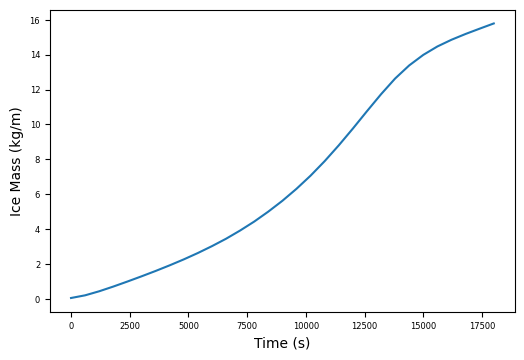

In [23]:
#Example of plotting variables that are a function of time
fig, axes = plt.subplots(dpi=100)
t_s = [i*60 for i in t]
axes.plot(t_s, ice_mass)
axes.set_xlabel("Time (s)")
axes.set_ylabel("Ice Mass (kg/m)")

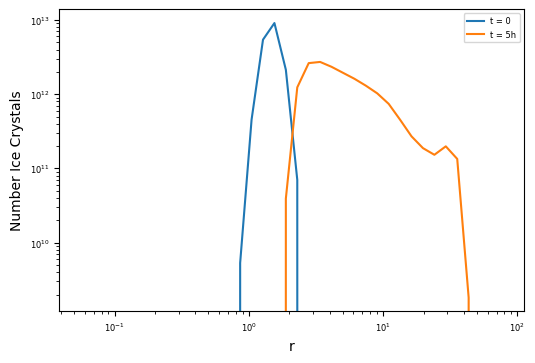

In [26]:
#Visualizing the evolution of the particle radius distribution over time
fig, axes = plt.subplots(dpi=100)
map=plt.plot(ds_t[0]['r'] * 1e6, removeLow(ds_t[0]["Overall size distribution"], cutoff = 1e9), label="t = 0")
map=plt.plot(ds_t[30]['r'] * 1e6, removeLow(ds_t[30]["Overall size distribution"], cutoff = 1e9), label="t = 5h")

axes.set_xlabel('r')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_ylabel('Number Ice Crystals')
plt.legend()
plt.show()

/tmp/ipykernel_45647/1807750886.py:6: RuntimeWarning: divide by zero encountered in log10
  map1 = ax11.contourf(-X + 2500, Y+1250, np.log10(removeLow(ds_t_2000['Ice aerosol particle number'])), cmap = 'jet')
/tmp/ipykernel_45647/1807750886.py:14: RuntimeWarning: divide by zero encountered in log10
  map2=ax12.contourf(-X+2500, Y+1250, np.log10(removeLow(ds_t_4000['Ice aerosol particle number'])), cmap = 'jet')
/tmp/ipykernel_45647/1807750886.py:23: RuntimeWarning: divide by zero encountered in log10
  map3=ax13.contourf(-X+2500, Y+1250, np.log10(removeLow(ds_t_17000['Ice aerosol particle number'])), cmap = 'jet')


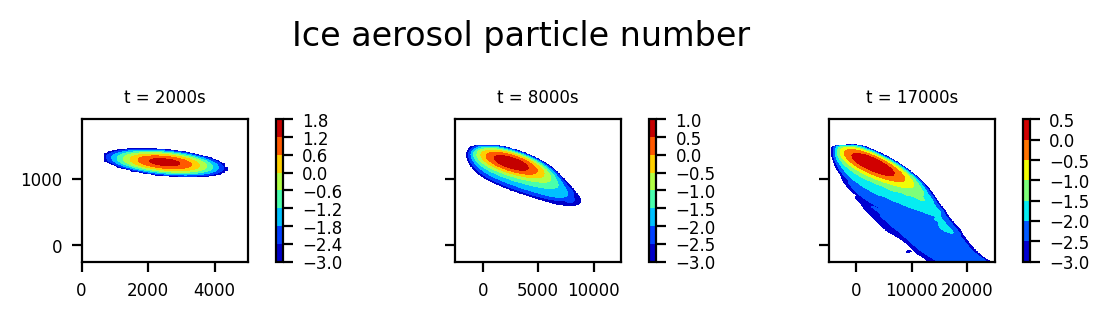

In [30]:
#Reproducing bulk features of Figure D1 in Fritz (2020)
fig, ((ax11, ax12, ax13)) = plt.subplots(nrows = 1, ncols = 3, figsize = [6,1.5], dpi=200, sharex=False, sharey=True)
fig.suptitle("Ice aerosol particle number")

ds_t_2000 = ds_t[3] + (1.0/3.0) * (ds_t[4] - ds_t[3])
map1 = ax11.contourf(-X + 2500, Y+1250, np.log10(removeLow(ds_t_2000['Ice aerosol particle number'])), cmap = 'jet')
ax11.set_title('t = 2000s')
ax11.set_xlim(0, 5000)
ax11.set_aspect(2.0)
plt.colorbar(map1, ax = ax11,fraction=0.046, pad=0.1)


ds_t_4000 = ds_t[13] + (1.0/3.0) * (ds_t[14] - ds_t[13])
map2=ax12.contourf(-X+2500, Y+1250, np.log10(removeLow(ds_t_4000['Ice aerosol particle number'])), cmap = 'jet')
ax12.set_title('t = 8000s')
ax12.set_xlim(-2500, 12500)
ar = 2*15000.0/5000
ax12.set_aspect(ar)
plt.colorbar(map2, ax = ax12,fraction=0.046, pad=0.1)


ds_t_17000 = ds_t[28] + (1.0/3.0) * (ds_t[29] - ds_t[28])
map3=ax13.contourf(-X+2500, Y+1250, np.log10(removeLow(ds_t_17000['Ice aerosol particle number'])), cmap = 'jet')
ax13.set_title('t = 17000s')
ax13.set_xlim(-5000, 25000)
ar = 2*(30000/5000)
ax13.set_aspect(ar)
plt.colorbar(map3, ax = ax13,fraction=0.046, pad=0.1)


fig.tight_layout(pad=1.0)

plt.show()

/tmp/ipykernel_45647/2560579260.py:6: RuntimeWarning: divide by zero encountered in log10
  map1 = ax11.contourf(-X + 2500, Y+1250, np.log10(removeLow(ds_t_2000['IWC']*1e6)), cmap = 'jet')
/tmp/ipykernel_45647/2560579260.py:14: RuntimeWarning: divide by zero encountered in log10
  map2=ax12.contourf(-X+2500, Y+1250, np.log10(removeLow(ds_t_4000['IWC']*1e6)), cmap = 'jet')
/tmp/ipykernel_45647/2560579260.py:23: RuntimeWarning: divide by zero encountered in log10
  map3=ax13.contourf(-X+2500, Y+1250, np.log10(removeLow(ds_t_17000['IWC']*1e6)), cmap = 'jet')


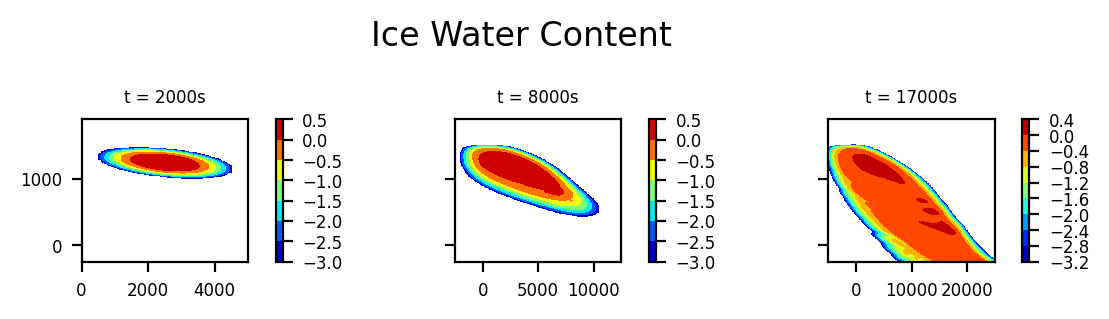

In [45]:
#Reproducing bulk features of Figure D1 in Fritz (2020)
fig, ((ax11, ax12, ax13)) = plt.subplots(nrows = 1, ncols = 3, figsize = [6,1.5], dpi=200, sharex=False, sharey=True)
fig.suptitle("Ice Water Content")

ds_t_2000 = ds_t[3] + (1.0/3.0) * (ds_t[4] - ds_t[3])
map1 = ax11.contourf(-X + 2500, Y+1250, np.log10(removeLow(ds_t_2000['IWC']*1e6)), cmap = 'jet')
ax11.set_title('t = 2000s')
ax11.set_xlim(0, 5000)
ax11.set_aspect(2.0)
plt.colorbar(map1, ax = ax11,fraction=0.046, pad=0.1)


ds_t_4000 = ds_t[13] + (1.0/3.0) * (ds_t[14] - ds_t[13])
map2=ax12.contourf(-X+2500, Y+1250, np.log10(removeLow(ds_t_4000['IWC']*1e6)), cmap = 'jet')
ax12.set_title('t = 8000s')
ax12.set_xlim(-2500, 12500)
ar = 2*15000.0/5000
ax12.set_aspect(ar)
plt.colorbar(map2, ax = ax12,fraction=0.046, pad=0.1)


ds_t_17000 = ds_t[28] + (1.0/3.0) * (ds_t[29] - ds_t[28])
map3=ax13.contourf(-X+2500, Y+1250, np.log10(removeLow(ds_t_17000['IWC']*1e6)), cmap = 'jet')
ax13.set_title('t = 17000s')
ax13.set_xlim(-5000, 25000)
ar = 2*(30000/5000)
ax13.set_aspect(ar)
plt.colorbar(map3, ax = ax13,fraction=0.046, pad=0.1)


fig.tight_layout(pad=1.0)

plt.show()

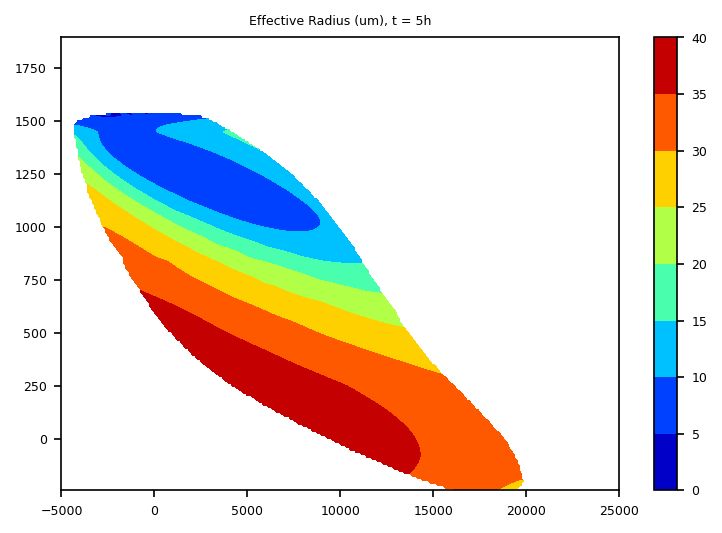

In [46]:
fig,ax = plt.subplots(dpi=150)
to_plot = ds_t[29]['Effective radius']*1e6
ax.set_xlim(-5000,25000)
ax.set_title("Effective Radius (um), t = 6h")
map1 = ax.contourf(-X+2500, Y+1250, np.ma.masked_array(to_plot, mask=np.log10(ds_t[20]['Ice aerosol particle number'])<-6), cmap='jet')
plt.colorbar(map1)
plt.show()

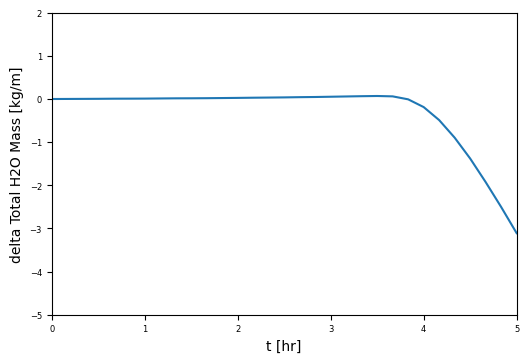

In [50]:
fig, axes = plt.subplots(dpi=100)
axes.plot(np.array(t)/60, np.array(total_h2o_mass - total_h2o_mass[0]))
axes.set_xlabel('t [hr]')
axes.set_ylabel('delta Total H2O Mass [kg/m]')
axes.set_xlim(0,5)
axes.set_ylim(-5, 2)
plt.show()